*It's custom ResNet trained demonstration purpose, not for accuracy.
Dataset used is cats_vs_dogs dataset from tensorflow_dataset with **ImageDataGenerator** for data augmentation*

---



### **1. Importing Libraries**





In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D, add, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize_with_pad, decode_jpeg, convert_image_dtype, decode_png
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
import os
%matplotlib inline


### **2. Loading & Processing Data**





##### **Loading Data**

In [ ]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)


###### **Note ->**

Well, it is unhealthy to convert them into DataFrame that require quit memory. I did because I was trying to do some DataFrame transformation which was costlier than I thought.

In [ ]:
train_ds = tfds.as_dataframe(train_ds, info)
val_ds = tfds.as_dataframe(val_ds, info)
test_ds = tfds.as_dataframe(test_ds, info)

In [ ]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [ ]:
train_ds.columns

Index(['image', 'label'], dtype='object')

In [ ]:
## Function to save images 
def pad_image(img, dest):
  img = Image.fromarray(img)                                    ## Opening Image File
  img_size = img.size
  target_size = max(img_size)
  ratio = 1.0
  new_size = tuple([int(x*ratio) for x in img_size])
  img2 = img.resize(new_size, Image.ANTIALIAS)
  new_img = Image.new("RGB", (target_size, target_size))
  new_img.paste(img, ((target_size-new_size[0])//2,
                        (target_size-new_size[1])//2))
  new_img.save(dest)
  img.close()
  img2.close()
  new_img.close()

  





In [ ]:
def pad_image2(img):
  img = Image.fromarray(img)                                    ## Opening Image File
  img_size = img.size
  target_size = max(img_size)
  ratio = 1.0
  new_size = tuple([int(x*ratio) for x in img_size])
  img2 = img.resize(new_size, Image.ANTIALIAS)
  new_img = Image.new("RGB", (target_size, target_size))
  new_img.paste(img, ((target_size-new_size[0])//2,
                        (target_size-new_size[1])//2))
  image = np.asarray(new_img, dtype=np.uint8)
  #new_img.save(dest)
  img.close()
  img2.close()
  new_img.close()
  return image

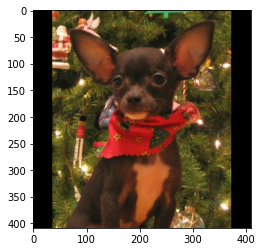

In [ ]:
s = train_ds.image[1]
s = pad_image2(s)
plt.imshow(s)

In [ ]:
## importand paths 
train_dir = 'train/'
test_dir = 'test/'
val_dir = 'val/'

In [ ]:
## Train image padding
if os.path.isdir(train_dir +'dog')!=True:
  os.makedirs(train_dir +'dog')
if os.path.isdir(train_dir +'cat')!=True:                                            
  os.makedirs(train_dir +'cat') 

for i, img in enumerate(train_ds.image):
  new_name = 'train' + str(i) + '.jpg'
  if train_ds.label[i]==1:
    save_dir = train_dir +'cat/' + new_name
  else:
    save_dir = train_dir +'dog/' + new_name
  pad_image(img, save_dir)
  
  


In [ ]:
## Test image padding
if os.path.isdir(test_dir +'dog')!=True:
  os.makedirs(test_dir +'dog')
if os.path.isdir(test_dir +'cat')!=True:                                            
  os.makedirs(test_dir +'cat') 

for i, img in enumerate(test_ds.image):
  new_name = 'test' + str(i) + '.jpg'
  if test_ds.label[i]==1:
    save_dir = test_dir +'cat/' + new_name
  else:
    save_dir = test_dir +'dog/' + new_name
  pad_image(img, save_dir)

In [ ]:
## Vallidation image padding
if os.path.isdir(val_dir +'dog')!=True:
  os.makedirs(val_dir +'dog')
if os.path.isdir(val_dir +'cat')!=True:                                            
  os.makedirs(val_dir +'cat') 

for i, img in enumerate(val_ds.image):
  new_name = 'val' + str(i) + '.jpg'
  if val_ds.label[i]==1:
    save_dir = val_dir +'cat/' + new_name
  else:
    save_dir = val_dir +'dog/' + new_name
  pad_image(img, save_dir)

####  **Data Augmentation**





In [ ]:
def normalization(img):
  #img = np.asarray(img, dtype=np.uint8)
  img = img/255.0
  return img

In [ ]:
batch_size = 32
shape = (224, 224, 3)
training_steps = int(18610/batch_size)
testing_steps = int(2326/batch_size)
path = '/content/drive/MyDrive/Colab Notebooks/Model/cats_v_dogs.h5'  

In [ ]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip=True,
                            preprocessing_function=normalization)

In [ ]:
testgen = ImageDataGenerator(preprocessing_function=normalization)

In [ ]:
train_ds = datagen.flow_from_directory('/content/train', target_size=(224, 224), batch_size=batch_size, shuffle=True)
test_ds = datagen.flow_from_directory('/content/test', target_size=(224, 224), batch_size=batch_size, shuffle=True)
val_ds = testgen.flow_from_directory('/content/val', target_size=(224, 224), batch_size=2326, shuffle=True)

Found 18610 images belonging to 2 classes.
Found 2326 images belonging to 2 classes.
Found 2326 images belonging to 2 classes.


## **3. Creating Model**

##### **Creating Residual block**

In [ ]:
def residual_block(x, feature_map, filter=(3,3) , _strides=(1,1), _neural_shortcut=False):
    shortcut = x
    x = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # _neural_shortcut used directly when the input and output are of the same dimensions
    if _neural_shortcut:
        shortcut = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = add([shortcut, x])
    x = ReLU()(x)

    return x

In [ ]:
# Build the model using the functional API
i = Input(shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = residual_block(x, 32, filter=(3,3) , _strides=(1,1), _network_shortcut=False)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = residual_block(x,64, filter=(3,3) , _strides=(1,1), _network_shortcut=False)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

### **4. Optimizer and loss Function** 

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
Optimiser = tf.keras.optimizers.Adam()

### **5. Metrics For Loss and Acuracy**

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

### **6. Function for training and Testing**

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

In [ ]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

### **7. Training Model**

In [ ]:
EPOCHS = 36
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = [] 

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  print(f'Epoch : {epoch+1}')

  count = 0  # variable to keep tab how much data steps of training
  desc = "EPOCHS {:0>4d}".format(epoch+1)

  for images, labels in tqdm(train_ds, total=training_steps, desc=desc):
    if count < training_steps:
      train_step(images, labels)
      count+=1
    else:
      break
  test_count = 0
  for test_images, test_labels in test_ds:
    if test_count < testing_steps :
      test_step(test_images, test_labels)
      test_count +=1
    else:
      break
    
  

  print(
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  ### Implementing  CallBack

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      
      print(f"Saving Best Model {epoch+1}")
      
      
  

      model.save_weights(path)                            # Saving Model To drive
      

Epoch : 1


Loss: 0.7603693604469299, Accuracy: 67.44298553466797, Test Loss: 0.6422534584999084, Test Accuracy: 65.0607681274414
Epoch : 2


Loss: 0.5077109932899475, Accuracy: 76.22095489501953, Test Loss: 0.5183739066123962, Test Accuracy: 76.90972137451172
Saving Best Model 2
Epoch : 3


Loss: 0.4277392029762268, Accuracy: 80.76592254638672, Test Loss: 0.7760514616966248, Test Accuracy: 65.88542175292969
Epoch : 4


Loss: 0.35736680030822754, Accuracy: 84.92900085449219, Test Loss: 0.35454094409942627, Test Accuracy: 83.94097137451172
Saving Best Model 4
Epoch : 5


Loss: 0.29351574182510376, Accuracy: 88.021728515625, Test Loss: 0.4599283039569855, Test Accuracy: 79.81770324707031
Epoch : 6


Loss: 0.24480374157428741, Accuracy: 90.18395233154297, Test Loss: 0.5094645023345947, Test Accuracy: 76.86631774902344
Epoch : 7


Loss: 0.20402176678180695, Accuracy: 91.89974212646484, Test Loss: 0.41097214818000793, Test Accuracy: 84.5920181274414
Epoch : 8


Loss: 0.17569789290428162, Accuracy: 93.06690979003906, Test Loss: 0.19472607970237732, Test Accuracy: 91.44965362548828
Saving Best Model 8
Epoch : 9


Loss: 0.1676490604877472, Accuracy: 93.36811065673828, Test Loss: 0.26263558864593506, Test Accuracy: 89.53993225097656
Epoch : 10


Loss: 0.14967180788516998, Accuracy: 94.20181274414062, Test Loss: 0.9021989107131958, Test Accuracy: 64.49652862548828
Epoch : 11


Loss: 0.15452192723751068, Accuracy: 94.2824935913086, Test Loss: 0.24326393008232117, Test Accuracy: 90.0173568725586
Epoch : 12


Loss: 0.13834254443645477, Accuracy: 94.62134552001953, Test Loss: 0.36820030212402344, Test Accuracy: 84.46180725097656
Epoch : 13


Loss: 0.12630191445350647, Accuracy: 95.03012084960938, Test Loss: 0.13373158872127533, Test Accuracy: 94.44444274902344
Saving Best Model 13
Epoch : 14


Loss: 0.1182699054479599, Accuracy: 95.52495574951172, Test Loss: 0.31615176796913147, Test Accuracy: 88.75868225097656
Epoch : 15


Loss: 0.11723096668720245, Accuracy: 95.53033447265625, Test Loss: 0.14904481172561646, Test Accuracy: 94.44444274902344
Epoch : 16


Loss: 0.11169496923685074, Accuracy: 95.61639404296875, Test Loss: 0.14685563743114471, Test Accuracy: 94.140625
Epoch : 17


Loss: 0.10518553107976913, Accuracy: 95.94986724853516, Test Loss: 0.11783818155527115, Test Accuracy: 95.35590362548828
Saving Best Model 17
Epoch : 18


Loss: 0.10002099722623825, Accuracy: 96.06820678710938, Test Loss: 0.1509048044681549, Test Accuracy: 93.61979675292969
Epoch : 19


Loss: 0.10190363228321075, Accuracy: 96.0789566040039, Test Loss: 0.14758872985839844, Test Accuracy: 94.22743225097656
Epoch : 20


Loss: 0.09400568902492523, Accuracy: 96.27259063720703, Test Loss: 0.22620967030525208, Test Accuracy: 92.96875
Epoch : 21


Loss: 0.0905652567744255, Accuracy: 96.4554672241211, Test Loss: 0.12655368447303772, Test Accuracy: 95.18229675292969
Epoch : 22


Loss: 0.09031624346971512, Accuracy: 96.58992767333984, Test Loss: 0.15745237469673157, Test Accuracy: 93.70659637451172
Epoch : 23


Loss: 0.08072426915168762, Accuracy: 96.85348510742188, Test Loss: 0.1320447325706482, Test Accuracy: 94.57465362548828
Epoch : 24


Loss: 0.0838250145316124, Accuracy: 96.82121276855469, Test Loss: 0.16155293583869934, Test Accuracy: 93.61979675292969
Epoch : 25


Loss: 0.08677134662866592, Accuracy: 96.73515319824219, Test Loss: 0.11397234350442886, Test Accuracy: 95.5295181274414
Saving Best Model 25
Epoch : 26


Loss: 0.07585412263870239, Accuracy: 97.13855743408203, Test Loss: 0.12124300003051758, Test Accuracy: 95.61631774902344
Epoch : 27


Loss: 0.0813356265425682, Accuracy: 97.04174041748047, Test Loss: 0.10853765159845352, Test Accuracy: 96.09375
Saving Best Model 27
Epoch : 28


Loss: 0.0728272795677185, Accuracy: 97.26763916015625, Test Loss: 0.1431775838136673, Test Accuracy: 94.48784637451172
Epoch : 29


Loss: 0.06966188549995422, Accuracy: 97.32142639160156, Test Loss: 0.21795980632305145, Test Accuracy: 91.796875
Epoch : 30


Loss: 0.07527638971805573, Accuracy: 97.24613189697266, Test Loss: 0.12681715190410614, Test Accuracy: 94.87847137451172
Epoch : 31


Loss: 0.0634944811463356, Accuracy: 97.61725616455078, Test Loss: 0.21997183561325073, Test Accuracy: 92.88194274902344
Epoch : 32


Loss: 0.06654828041791916, Accuracy: 97.50430297851562, Test Loss: 0.1657261699438095, Test Accuracy: 94.57465362548828
Epoch : 33


Loss: 0.06776835769414902, Accuracy: 97.50968170166016, Test Loss: 0.1951548457145691, Test Accuracy: 92.96875
Epoch : 34


Loss: 0.06804052740335464, Accuracy: 97.62800598144531, Test Loss: 0.11716222763061523, Test Accuracy: 95.703125
Epoch : 35


Loss: 0.05939412862062454, Accuracy: 97.89694213867188, Test Loss: 0.14906564354896545, Test Accuracy: 95.05207824707031
Epoch : 36


Loss: 0.06564906239509583, Accuracy: 97.46127319335938, Test Loss: 0.11194691061973572, Test Accuracy: 95.78993225097656


### **8. Ploting Loss and Accuracy Per Iteration**

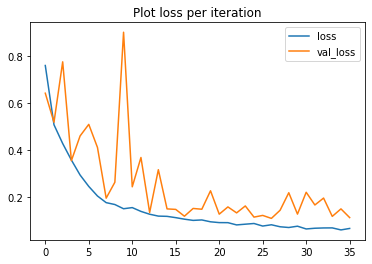

In [ ]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

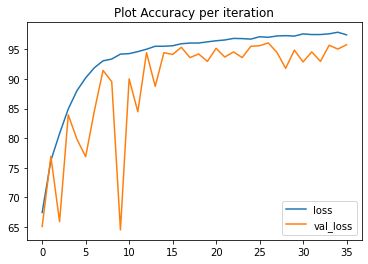

In [ ]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()

## 9. Evoluting model

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Model/cats_v_dogs.h5')

In [ ]:

for images, labels in val_ds:
  prediction = model.predict(images)
  break
 


In [ ]:
  
def accuracy(prediction, labels):
    corect =0
    for i in range(len(prediction)):
      pred = prediction[i]
      labe = labels[i]
      if pred[0]>pred[1] and labe[0]>labe[1]:
        corect+=1
      elif pred[0]<pred[1] and labe[0]<labe[1]:
        corect+=1
    
    return (corect/len(prediction))*100



In [ ]:
print(accuracy(prediction, labels))

96.04471195184867
